In [1]:
# Import necessary libraries
import os
import random
import tensorflow as tf
import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

#Hyper parameters
epochs = 2 #20
n_estimators = 5 #50

# Set random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

# Set the image size
image_size = (128, 128)

# Define label names
label_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

DATA PREPARATION

In [2]:
def process_folders(folder_path):
    # Initialize lists to store image data and targets
    image_data = []
    targets = []
    # Process images in each subfolder
    for class_folder in os.listdir(folder_path):
        class_folder_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_folder_path):
            for filename in os.listdir(class_folder_path):
                if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
                    img_path = os.path.join(class_folder_path, filename)
                    try:
                        with Image.open(img_path) as img:
                            #img = img.convert('L') convert to grayscale
                            # Resize the image
                            img = img.resize(image_size)
                            #img = np.array(img).flatten()  # Flatten the image array

                            # Append the image data and target to the lists
                            image_data.append(np.array(img))
                            targets.append(class_folder)

                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

    # Create dataframes from the lists
    data = np.array(image_data)
    target = np.array(targets)

    return data, target

In [3]:
x_train, y_train = process_folders('Training')
x_test, y_test = process_folders('Testing')


# Display the first few rows of each dataframe

#print("Image data dataframe:")
#print(data_df.head())

#print("\nTarget dataframe:")
#print(y_train.head())

# Check the shape of the data to confirm it matches 64x64 = 4096
print("\nShape of X_TRAIN data array:", x_train.shape)
print("\nShape of Y_TRAIN data array:", y_train.shape)
print("\nShape of X_TEST data array:", x_test.shape)
print("\nShape of Y_TEST data array:", y_test.shape)



Shape of X_TRAIN data array: (2870, 128, 128, 3)

Shape of Y_TRAIN data array: (2870,)

Shape of X_TEST data array: (394, 128, 128, 3)

Shape of Y_TEST data array: (394,)


* Even though the images are in black and white, we keep the three channels R, G, B because the VGG16 that will later be used requires the images in this format
* The Random Forest model that will later be used will have the matrices flattened

In [4]:
# Count the number of images for each class in y_train and y_test arrays
class_counts_train = Counter(y_train)
class_counts_test = Counter(y_test)

# Display the counts
print("\nNumber of images for each class in y_train:")
print(class_counts_train)

print("\nNumber of images for each class in y_test:")
print(class_counts_test)



Number of images for each class in y_train:
Counter({'pituitary_tumor': 827, 'glioma_tumor': 826, 'meningioma_tumor': 822, 'no_tumor': 395})

Number of images for each class in y_test:
Counter({'meningioma_tumor': 115, 'no_tumor': 105, 'glioma_tumor': 100, 'pituitary_tumor': 74})


* There is a problem with the distrubtion of the different classes, there are about half as many images in no_tumor as in the other classes for the training set
* The distribution of the test set seems adequeate


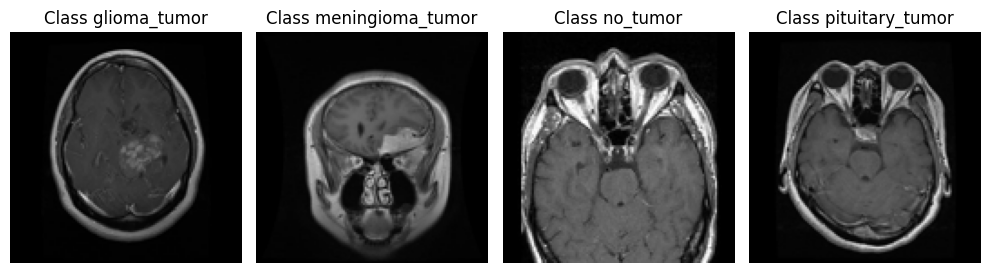

In [5]:
# Plot an image from each class in a subplot
def plot_images_by_class(X, y):
    unique_classes = np.unique(y)

    nrows = 1
    ncols = 4  # Number of columns in the subplot grid
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5))  # Adjust figsize as needed


    for i, class_label in enumerate(unique_classes):
        class_indices = np.where(y == class_label)[0]
        sample_index = class_indices[0]  # Select the first image for each class
        image = X[sample_index]
        axes[i].imshow(image, cmap='gray')  # Assuming images are grayscale
        axes[i].set_title(f"Class {class_label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_images_by_class(x_train, y_train)


PRE PROCESSING

In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Normalize input data (assuming x_train and x_test are already defined)
x_train = x_train / 255.0  # Assuming input data is pixel values ranging from 0 to 255
x_test = x_test / 255.0  # Assuming input data is pixel values ranging from 0 to 255

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder to the combined target data (y_train and y_test) and transform the class labels into numerical values
label_encoder.fit(np.concatenate((y_train, y_test)))

# Transform y_train and y_test arrays to numerical values
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the numerical labels
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes=num_classes)
y_test = to_categorical(y_test_encoded, num_classes=num_classes)


# Concatenate all the dataset
y_data = np.concatenate((y_train, y_test))
x_data = np.concatenate((x_train, x_test))

# Perform train-test split with shuffling
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=len(y_test), random_state=42, shuffle=True)

# Print number of classes detected
print(f"Number of classes detected: {num_classes}")
print("y_train shape after encoding and shuffling" + str(y_train.shape) + "\n")
print("First rows of Y_TRAIN after encoding:")
print(y_train[:5])

Number of classes detected: 4
y_train shape after encoding and shuffling(2870, 4)

First rows of Y_TRAIN after encoding:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


* The Y_Train data array has been 1-hot encoded so it has four dimensions

In [7]:
# Flatten y_train to treat it as a single-dimensional array
flattened_y_train = y_train.argmax(axis=1)

# Count occurrences of each class label
class_counts = np.bincount(flattened_y_train)

# Print the counts for each class
print("New distribution of classes in training set")
for class_label, count in enumerate(class_counts):
    print(f"Class {label_names[class_label]}: {count} instances")

New distribution of classes in training set
Class glioma_tumor: 794 instances
Class meningioma_tumor: 837 instances
Class no_tumor: 439 instances
Class pituitary_tumor: 800 instances


* After re doing the train test split and applying a new shuffle, we note that the distribution of the classes is pretty much the same

MODEL 0: Random Forest

In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Flatten the images
n_samples = x_train.shape[0]
x_train_flat = x_train.reshape(n_samples, -1)  
n_samples = x_test.shape[0]
x_test_flat = x_test.reshape(n_samples, -1)  

#Multi class classification instead of multi label
y_train_rf = np.argmax(y_train, axis=1)
y_test_rf = np.argmax(y_test, axis=1)

# Initialize k-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

# Perform k-fold cross-validation
cross_val_scores = cross_val_score(clf, x_train_flat, y_train_rf, cv=skf, scoring='accuracy') #Data leakage?

# Train the model on the entire training set
clf.fit(x_train_flat, y_train_rf)

RandomForestClassifier(n_estimators=5, random_state=42)

Cross-validation scores for each fold: [0.80487805 0.81358885 0.82578397 0.83623693 0.83101045]
Mean cross-validation score: 0.8222996515679443

                  precision    recall  f1-score   support

    glioma_tumor       0.87      0.78      0.82       132
meningioma_tumor       0.71      0.84      0.77       100
        no_tumor       0.88      0.82      0.85        61
 pituitary_tumor       0.95      0.93      0.94       101

        accuracy                           0.84       394
       macro avg       0.85      0.84      0.84       394
    weighted avg       0.85      0.84      0.84       394



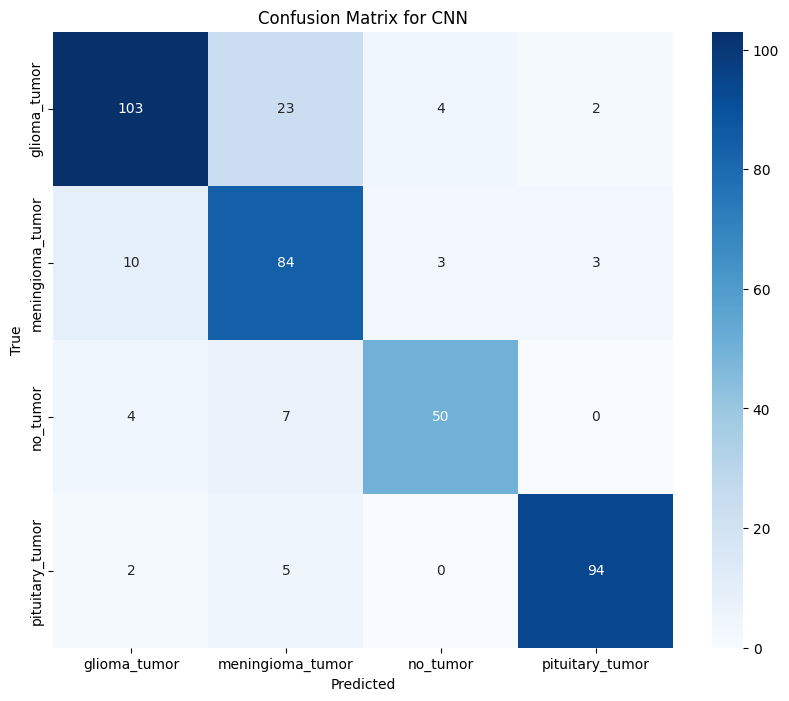

In [9]:
# Print cross-validation scores
print(f'Cross-validation scores for each fold: {cross_val_scores}')
print(f'Mean cross-validation score: {cross_val_scores.mean()}\n')

# Predict on the test set
y_pred = clf.predict(x_test_flat)

# Print classification report
print(classification_report(y_test_rf, y_pred, target_names=label_names))

#Confusion matrix
cm = confusion_matrix(y_test_rf, y_pred)
#print("Confusion Matrix VGG16:")
#print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CNN')
plt.show()


MODEL 1: Convolutional Neural Network

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Define the CNN model with Dropout and ImageDataGenerator
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Adding dropout after the first convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Adding dropout after the second convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Adding dropout after the third convolutional layer
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Adding dropout before the output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model and store history
history_1 = model.fit(x_train, y_train, epochs=epochs, batch_size=32, 
                      validation_split=0.2, verbose=1,
                      callbacks=[early_stopping])

# Evaluate the model on test data
predictions = model.predict(x_test, verbose=1)




Epoch 1/2


72/72 [==============================] - 17s 197ms/step - loss: 1.1776 - accuracy: 0.4713 - val_loss: 0.9518 - val_accuracy: 0.6463
Epoch 2/2
13/13 [==============================] - 1s 32ms/step


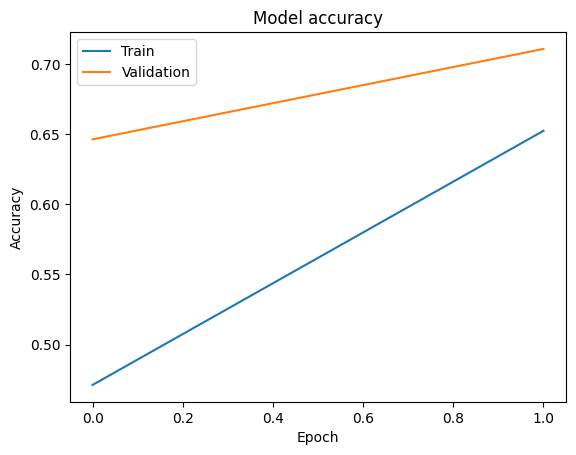

                  precision    recall  f1-score   support

    glioma_tumor       0.75      0.69      0.72       132
meningioma_tumor       0.56      0.63      0.59       100
        no_tumor       0.66      0.51      0.57        61
 pituitary_tumor       0.83      0.93      0.88       101

        accuracy                           0.71       394
       macro avg       0.70      0.69      0.69       394
    weighted avg       0.71      0.71      0.70       394

13/13 [==============================] - 0s 33ms/step - loss: 0.6930 - accuracy: 0.7081
CNN Test Accuracy: 0.7081


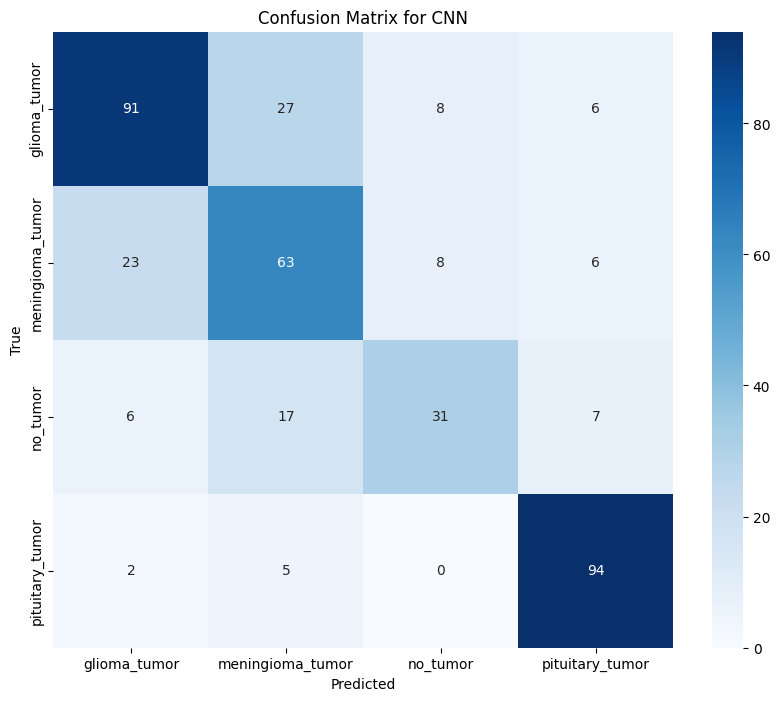

In [11]:
y_pred_classes = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot training & validation accuracy values
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=label_names))

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"CNN Test Accuracy: {test_accuracy:.4f}")

#Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
#print("Confusion Matrix VGG16:")
#print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CNN')
plt.show()


MODEL 2: VGG16 TRANSFER LEARNING

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import VGG16
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from keras.utils import to_categorical

# Assuming you have x_train, y_train, x_test, y_test defined

# Load pre-trained VGG16 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze initial layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Add new layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Optionally, print model summary
#model.summary()

# Train the model and store history
history_2 = model.fit(x_train, y_train, epochs=epochs, batch_size=32,
                    validation_split=0.2, verbose=1)
                    
# Evaluate the model
y_pred = model.predict(x_test, verbose = 1)

Epoch 1/2
72/72 [==============================] - 74s 1s/step - loss: 0.8124 - accuracy: 0.6786 - val_loss: 0.5272 - val_accuracy: 0.8136
Epoch 2/2
13/13 [==============================] - 11s 828ms/step


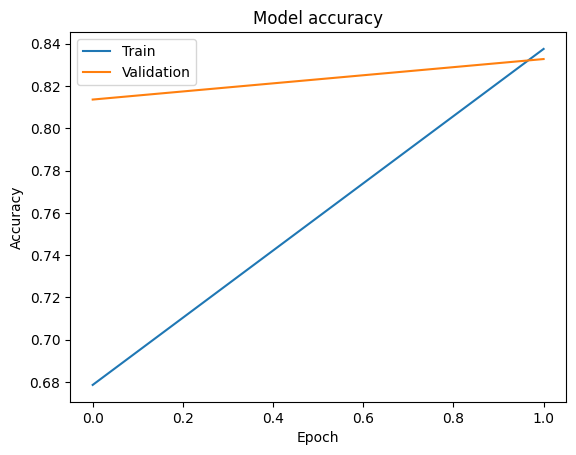

                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.75      0.82       132
meningioma_tumor       0.69      0.86      0.77       100
        no_tumor       0.83      0.74      0.78        61
 pituitary_tumor       0.94      0.99      0.97       101

        accuracy                           0.84       394
       macro avg       0.84      0.83      0.83       394
    weighted avg       0.85      0.84      0.84       394

13/13 [==============================] - 11s 826ms/step - loss: 0.4316 - accuracy: 0.8376
VGG16 Test Accuracy: 0.8376


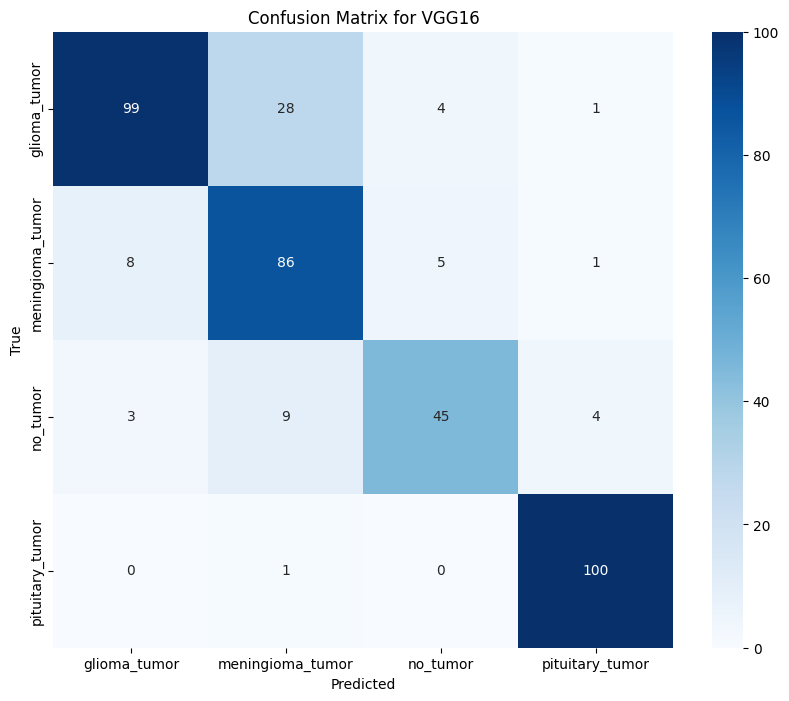

In [13]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot training & validation accuracy values
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=label_names))

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"VGG16 Test Accuracy: {test_accuracy:.4f}")

#Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
#print("Confusion Matrix VGG16:")
#print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for VGG16')
plt.show()


* With 10 Epochs for the neural networks and 100 estimators for the Random Forest classifier we can state that best model by a small margin is the VGG16 with transfer learning (92 % test accuracy after 20 epochs)
* Generally the models perform well with an average accuracy of 92 %
* The class No_tumor does not have a high enough precision ( too many false positives), we want the models to be very confident when predicting that a patient does not have a tumor
* To solve thes eproblems we plan on performing data augmentation to have more diverse images of glioma tumor and to increase threshold for no_tumor so the model is more sure of a positive output
* We make sure that the data augmentation leads to a more evenly distributed dataset, we make sure that the transformations applied have real life relevance

DATA AUGMENTATION: GLIOMA AND NO_TUMOR IMPROVEMENT

In [14]:
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator with relevant augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,  # Slight rotations within 10 degrees
    zoom_range=0.1,     # Slight zoom in/out within 10%
    horizontal_flip=True  # Horizontal flip
)

# Initialize lists to collect augmented images and labels
augmented_images_list = []
augmented_labels_list = []

# Define class sizes after augmentation
no_tumor_target_size = 500  # Target number of no_tumor images after augmentation
counter = 0

# Loop through all images in x_train
for i in range(x_train.shape[0]):
    image = x_train[i].reshape((1,) + x_train[i].shape)  # Reshape for ImageDataGenerator
    label = y_train[i]

    # Check if the label corresponds to no_tumor ([0., 0., 1., 0.])
    if np.array_equal(label, [0., 0., 1., 0.]):
        # Generate and collect augmented image
        for i in range(3):
            augmented_image = next(datagen.flow(image, batch_size=1))[0]
            augmented_images_list.append(augmented_image)
            augmented_labels_list.append(label)
        
        counter += 3
        
        # Break the loop if we have reached the target size
        if counter >= no_tumor_target_size:
            break

Data augmentation and shuffling completed.
Total number of training images after augmentation: 3371
Total number of training labels after augmentation: 3371


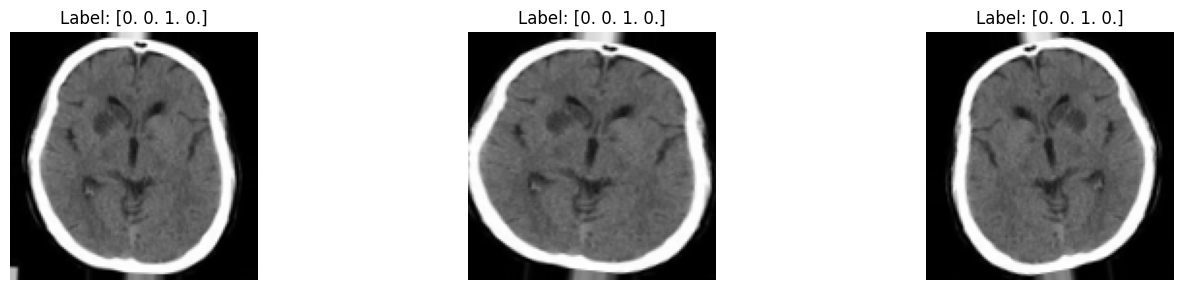

In [15]:
# Convert the list of augmented images and labels to numpy arrays
augmented_images = np.array(augmented_images_list)
augmented_labels = np.array(augmented_labels_list)

# Combine original and augmented images and labels
x_train = np.concatenate((x_train, augmented_images), axis=0)
y_train = np.concatenate((y_train, augmented_labels), axis=0)

# Shuffle the combined dataset
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

print(f"Data augmentation and shuffling completed.")
print(f"Total number of training images after augmentation: {x_train.shape[0]}")
print(f"Total number of training labels after augmentation: {y_train.shape[0]}")

# Plot some augmented images 
n_examples = 3  # Number of augmented images to plot
fig, axes = plt.subplots(nrows=1, ncols=n_examples, figsize=(15, 3))

for i in range(n_examples):
    axes[i].imshow(augmented_images[i])
    axes[i].set_title(f"Label: {augmented_labels[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


* Examples of transformations applied to the same image of glioma tumor
* We applied data augmentation ONLY to images of the training set
* We make sure to RESHUFFLE the training set, so that the augmented images are mixed with the original images

In [16]:
# Assuming y_train is your ndarray of labels with shape (2180, 4)
# Example: y_train.shape = (2180, 4)

# Flatten y_train to treat it as a single-dimensional array
flattened_y_train = y_train.argmax(axis=1)

# Count occurrences of each class label
class_counts = np.bincount(flattened_y_train)

# Print the counts for each class
print("New distribution of classes in training set")
for class_label, count in enumerate(class_counts):
    print(f"Class {label_names[class_label]}: {count} instances")


New distribution of classes in training set
Class glioma_tumor: 794 instances
Class meningioma_tumor: 837 instances
Class no_tumor: 940 instances
Class pituitary_tumor: 800 instances


We now have a more even distribution of the training set, we hope this improves the robustness of the model

MODEL 4: Transfer Learning after Data Augmentation

In [17]:
# Load pre-trained VGG16 model with ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze initial layers of VGG16
for layer in base_model.layers:
    layer.trainable = False

# Add new layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Optionally, print model summary
#model.summary()

# Train the model and store history
history_3 = model.fit(x_train, y_train, epochs=epochs, batch_size=32,
                    validation_data=(x_test, y_test), verbose=1)
                    
# Evaluate the model
y_pred = model.predict(x_test, verbose = 1)

Epoch 1/2
106/106 [==============================] - 107s 1s/step - loss: 0.8100 - accuracy: 0.6947 - val_loss: 0.5487 - val_accuracy: 0.7919
Epoch 2/2
13/13 [==============================] - 11s 822ms/step


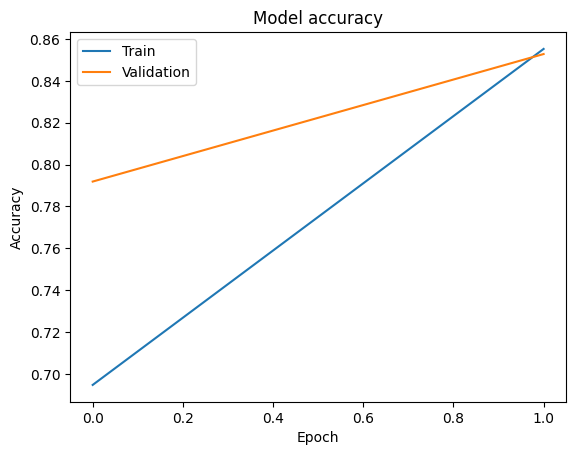

                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.80      0.85       132
meningioma_tumor       0.75      0.79      0.77       100
        no_tumor       0.80      0.85      0.83        61
 pituitary_tumor       0.92      0.99      0.95       101

        accuracy                           0.85       394
       macro avg       0.85      0.86      0.85       394
    weighted avg       0.86      0.85      0.85       394

13/13 [==============================] - 11s 826ms/step - loss: 0.4217 - accuracy: 0.8528
VGG16 + Data Augmentation Test Accuracy: 0.8528


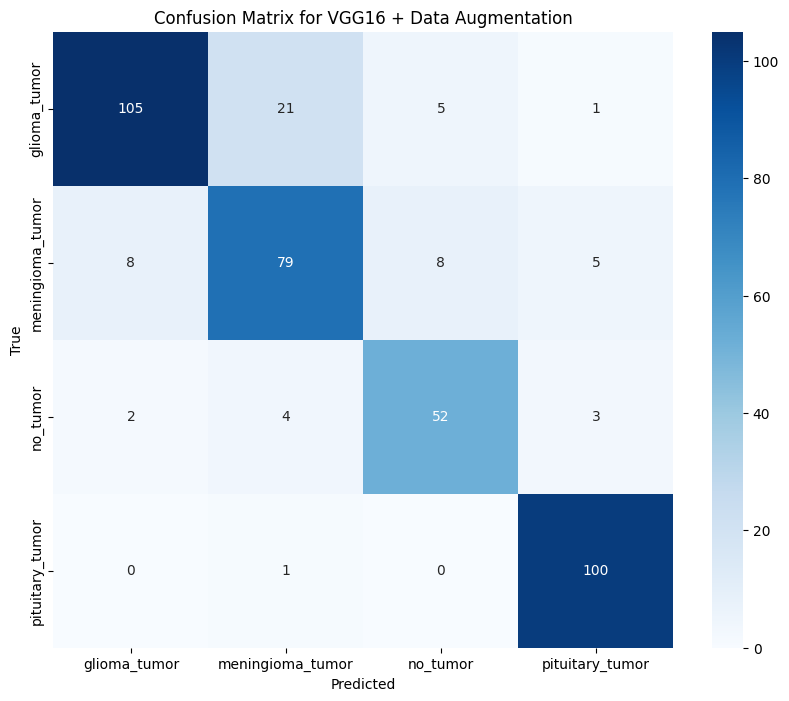

In [18]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Plot training & validation accuracy values
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=label_names))

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"VGG16 + Data Augmentation Test Accuracy: {test_accuracy:.4f}")

#Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
#print("Confusion Matrix VGG16:")
#print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for VGG16 + Data Augmentation')
plt.show()


In [19]:
from datetime import datetime
import os

# Get the current time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

# Format the filename
filename = f"model_epochs_{epochs}_{current_time}.h5"

# Save the model
model.save(os.path.join('saved_models', filename))

print(f"Model saved as: saved_models/{filename}")

Model saved as: saved_models/model_epochs_2_20240702_164922.h5


c:\Users\paule\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


* Data Augmentaiton does not seem to improve results by much 

Conclusion:
Throughout this project we applied the fundamental skills in machine learning to a multi class classification problem
We applied the standard machine learning process: data preparation, pre processing, model selection, training and model evaluation
The results that we obtained seem positive, we could further improve the project by adding an ensemble mechanism with different models trained on different parts of the dataset, a voting process could be used to find the best prediction